<a href="https://colab.research.google.com/github/Petra865/project/blob/Workstream/Petra_von_Main_TweetDisasterDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Twitter Disaster Detection

<center>

# Load Libs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta, time

In [ ]:
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, plot_confusion_matrix

from sklearn.naive_bayes import CategoricalNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#cv = CountVectorizer()
#bow_cv = cv.fit_transform(df["_lemmatized"])

## Helper function

In [ ]:
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()


def clean_text(text):
  # get rid of all unwanted punctuation and digits
  text = text.replace("´", "'")

  digi_punct = "[^a-zA-Z' ]"
  text = re.sub(digi_punct, " ", text)
  text = " ".join(text.split())
  text = text.lower()

  return text

def my_df_text_mining(df, col):
  lemmatizer = WordNetLemmatizer()
  my_stopwords = stopwords.words("english")
  
  df["_no_stopwords"] = df[col].apply(             lambda texxt: " ".join([word for word in clean_text(texxt).split() if word not in my_stopwords]))
  df[col]             = df["_no_stopwords"].apply( lambda texxt: " ".join([lemmatizer.lemmatize(word) for word in texxt.split()]) )

  return df.drop(["_no_stopwords"], axis=1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load data

[Link to data (csv) @google drive](https://drive.google.com/file/d/1QPragNh_wYQVsXQvds8sqjDMfzARD638/view?usp=sharing)


In [ ]:
url = 'https://raw.githubusercontent.com/TTD-JPO/TDD-project/main/disaster_tweets.csv'
disaster_tweets = pd.read_csv(url, encoding='latin-1')

# Evaluate data

## add main

In [ ]:
disaster_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


#in main

In [ ]:
print( "absolute number of disaster indicated messages:", disaster_tweets.target.sum() )
print( f"relative number of disaster indicated messages: {disaster_tweets.target.sum() / disaster_tweets.shape[0] :0.3f}" )

absolute number of disaster indicated messages: 3271
relative number of disaster indicated messages: 0.430


In [ ]:
keys      = list(disaster_tweets.keyword.unique() )
locations = list(disaster_tweets.location.unique() )

In [ ]:
disaster_tweets.groupby('keyword').target.count().sort_values(ascending=False)

keyword
fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: target, Length: 221, dtype: int64

In [ ]:
disaster_tweets.groupby('location').target.count().sort_values(ascending=False)

location
USA                            104
New York                        71
United States                   50
London                          45
Canada                          29
                              ... 
Republica Dominicana             1
Republic of the Philippines      1
Regalo Island                    1
Redondo Beach, CA                1
                                 1
Name: target, Length: 3341, dtype: int64

In [ ]:
display( f"relative number of keyword   messages: {disaster_tweets.keyword.nunique()  / disaster_tweets.shape[0] :0.3f}" )
display( f"relative number of location  messages: {disaster_tweets.location.nunique() / disaster_tweets.shape[0] :0.3f}" )

'relative number of keyword   messages: 0.029'

'relative number of location  messages: 0.439'

In [ ]:
### we might do these steps later after having processed the text :)
#dt = disaster_tweets.copy()

##clean

In [ ]:
dt = my_df_text_mining(disaster_tweets, 'text')

In [ ]:
dt.tail(3)

,id,keyword,location,text,target
7610,10871,NaN,NaN,utc km volcano hawaii http co zdtoyd ebj,1
7611,10872,NaN,NaN,police investigating e bike collided car littl...,1
7612,10873,NaN,NaN,latest home razed northern california wildfire...,1


##NLP keyword, localization

In [ ]:
missing_cols = ['keyword', 'location']

In [ ]:
X_train, y_test = train_test_split(disaster_tweets,
                  test_size=0.2,
                  random_state=314159)

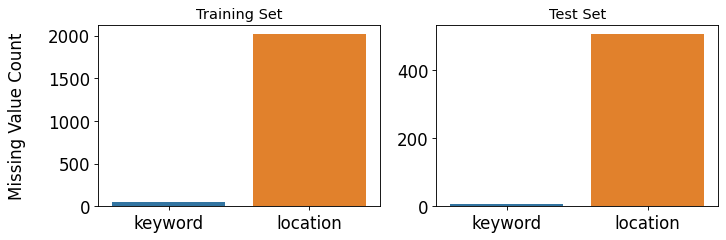

In [ ]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(10, 3), dpi=80)

sns.barplot(x=X_train[missing_cols].isnull().sum().index, y=X_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=y_test[missing_cols].isnull().sum().index, y=y_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

In [ ]:
# nan
for df in [X_train, y_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
print(sorted(X_train['keyword'].unique()))

['ablaze', 'accident', 'aftershock', 'airplane%20accident', 'ambulance', 'annihilated', 'annihilation', 'apocalypse', 'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked', 'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze', 'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood', 'bloody', 'blown%20up', 'body%20bag', 'body%20bagging', 'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse', 'buildings%20burning', 'buildings%20on%20fire', 'burned', 'burning', 'burning%20buildings', 'bush%20fires', 'casualties', 'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency', 'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided', 'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew', 'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris', 'deluge', 'deluged', 'demolish', 'demolished', 'demolition', 'derail', 'derailed', 'derailment', 'desolate', 'desolation', 'destroy', 'destroyed', 'destruction', 'detonate', 'detonatio

In [ ]:
X_train.head()

,id,keyword,location,text,target,_no_stopwords
5474,7812,quarantine,no_location,reddit update content policy promise quarantin...,0,reddit updates content policy promises quarant...
5687,8116,rescued,southern california,brave little dog get rescued river recovery in...,0,brave little dog gets rescued river recovery i...
4261,6055,heat%20wave,Somewhere in Spain,klarajoelsson well seen that's bummer we've he...,1,klarajoelsson well seen that's bummer we've he...
6932,9942,trouble,no_location,charleyisqueen yeah well maybe barber cut hair...,0,charleyisqueen yeah well maybe barber cut hair...
7239,10367,weapons,West,wwii memory plus lesson hiroshima still need n...,1,wwii memories plus lessons hiroshima still nee...


### fillna 'keyword', 'location' in disaster_tweets (gesamte Datei)

In [ ]:
for col in  missing_cols:
    disaster_tweets[col] = disaster_tweets[col].fillna(f'no_{col}')

In [ ]:
len(sorted(disaster_tweets['keyword'].unique()))

212

In [ ]:
####geht nicht siehe nachfolgende Zelle
dt_keywords = my_df_text_mining(disaster_tweets, 'keyword')

In [ ]:
dt_keywords.head()

,id,keyword,location,text,target
0,1,keyword,no_location,deed reason earthquake may allah forgive u,1
1,4,keyword,no_location,forest fire near la ronge sask canada,1
2,5,keyword,no_location,resident asked 'shelter place' notified office...,1
3,6,keyword,no_location,people receive wildfire evacuation order calif...,1
4,7,keyword,no_location,got sent photo ruby alaska smoke wildfire pour...,1


In [ ]:
sorted(disaster_tweets['keyword'].unique())[:10]

['ablaze',
 'accident',
 'aftershock',
 'airplane accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army']

###split


In [ ]:
### ist durch zelle mit missing col überflüssig
no_keyword_ = dt[  dt.keyword.isna()]
keyword_    = dt[ ~dt.keyword.isna()]

In [ ]:
### ist durch zelle mit missing col überflüssig
no_location_ = dt[  dt.location.isna()]
location_    = dt[ ~dt.location.isna()]

In [ ]:
no_target_ = dt[ dt.target == 0]
target_    = dt[ dt.target == 1]

### lemmatized

In [ ]:
location_

# Visualization of data (of)

In [ ]:
df = disaster_tweets

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df['target'], hue=df['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in dataset', fontsize=13)
axes[1].set_title('Target Count in dataset', fontsize=13)

plt.show()

## Modeling

In [ ]:
df    = dt.copy()


In [ ]:
#tfidf_v = TfidfVectorizer(ngram_range=(1, 2))
#tfidf_bow = tfidf_v.fit_transform(df["_lemmatized"])   # FIT and transform to learn
### ??? wo wird das denn weiterverwendet ???

In [ ]:
#tfidf_v.transform(no_df['_lemmatized'])  # only transformation!!!

## Train-Test-Split

In [ ]:
X_train, X_test,\
y_train, y_test =\
 train_test_split(df["text"],
                  df["target"],
                  test_size=0.2,
                  random_state=314159,
                  stratify=df["target"])

##pipline Tfidf, MultinomialNB

In [ ]:
#### naive bayes 
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB())

display( cross_val_score(pipeMNB, X_train, y_train).mean() )

pipeMNB.fit(X_train, y_train)

plot_confusion_matrix(pipeMNB, X_test, y_test, values_format="0.3f", normalize='true', cmap="RdYlGn")
plt.title(f"best accuracy: { accuracy_score(y_test, pipeMNB.predict(X_test)):0.3f}")
plt.show()

In [ ]:

df=disaster_tweets

X_train, X_test,\
y_train, y_test =\
 train_test_split(df["text"],
                  df["target"],
                  test_size=0.2,
                  random_state=314159,
                  stratify=df["target"])


#### naive bayes 
pipeMNB = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), MultinomialNB())

display( cross_val_score(pipeMNB, X_train, y_train).mean() )

pipeMNB.fit(X_train, y_train)

plot_confusion_matrix(pipeMNB, X_test, y_test, values_format="0.3f", normalize='true', cmap="RdYlGn")
plt.title(f"best accuracy: { accuracy_score(y_test, pipeMNB.predict(X_test)):0.3f}")
plt.show()